VQA

Problem Statement:

Visual Question Answering (VQA) is the task of answering open-ended questions based on an image. VQA has many applications: Medical VQA, Education purposes, for surveillance and numerous other applications. In this assignment we will use VizWiz dataset, this dataset was constructed to train models to help visually impaired people.
In the words of creators of VizWiz: “we introduce the visual question answering (VQA) dataset coming from this population, which we call VizWiz-VQA. It originates from a natural visual question answering setting where blind people each took an image and recorded a spoken question about it, together with 10 crowdsourced answers per visual question.”

In [7]:
!pip install ftfy regex tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 3.0 MB/s eta 0:00:00


In [8]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-7kpuf86j
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-7kpuf86j
  Resolved https://github.com/openai/CLIP.git to commit a9b1bf5920416aaeaec965c25dd9e8f98c864f16
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369410 sha256=afc61a869135e6c01be333a09ecb2c3769fbd57c48ca436ba1fb649813745549
  Stored in directory: /tmp/pip-ephem-wheel-cache-oq72wtyq/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


In [227]:
import os
import json
import numpy as np
import pandas as pd
from PIL import Image

import clip
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.optim.lr_scheduler as lr_scheduler
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader
from collections import Counter
from functools import lru_cache
import matplotlib.image as mpimg



pd.set_option('display.max_colwidth', None)

In [2]:
JSONS_DIR = "/kaggle/input/d/lhanhsin/vizwiz/Annotations/Annotations/"
IMAGES_DIR = "/kaggle/input/d/lhanhsin/vizwiz/"

In [6]:
! cat  /content/data/Annotations/README.txt

cat: /content/data/Annotations/README.txt: No such file or directory


## Data loading:

In [228]:
def show_histogram_plot(data, title, top=10):
    print(data)
    # Plot the histogram
    data.head(top).plot.bar()

    # Set labels and title
    plt.xlabel('Unique Values')
    plt.ylabel('Count')
    plt.title('Histogram of '+title)

    # Display the plot
    plt.show()

    

def show_image(name, file_dir=IMAGES_DIR):
    image = mpimg.imread(file_dir+name)
    plt.imshow(image)
    plt.axis('off')
    plt.show()




def open_json(path):
    # Opening JSON file
    file = open(path)

    # returns JSON object as a dictionary
    data = json.load(file)

    # Closing file
    file.close()
    return data



def get_data(path):
    # reading the json file
    json_data = open_json(path)

    # init empty Dataframe
    data = pd.DataFrame(columns=[
        'questions'
        ,'answerable'
        ,'answer_type'
        ,'answers'
        ,'answer_confidence'
        ,'images_names'
        ])

    for record in json_data:
        question_answers = []
        ans_confidence = []
        for answer in record['answers']:
            ans_confidence.append(answer['answer_confidence'])
            question_answers.append(answer['answer'])

        row = pd.Series([
            record['question']
            ,record['answerable']
            ,record['answer_type']
            ,question_answers
            ,ans_confidence
            ,record['image']
            ], index=data.columns).to_frame().T

        # Concatenate the transposed rows with the existing DataFrame
        data = pd.concat([data, row], ignore_index=True)

    return data



def encode_confidence(data):
    '''
    Yes -> 3
    maybe -> 2
    No -> 1
    '''
    for i in range(len(data['answer_confidence'])):
          for j in range(10):
            if data['answer_confidence'][i][j] == 'yes':
                data['answer_confidence'][i][j] = 3
            elif data['answer_confidence'][i][j] == 'no':
                data['answer_confidence'][i][j] = 1
            else:
                data['answer_confidence'][i][j] = 2
    return data



def lev_dist(a, b):
    @lru_cache(None)  # for memorization
    def min_dist(s1, s2):

        if s1 == len(a) or s2 == len(b):
            return len(a) - s1 + len(b) - s2

        # no change required
        if a[s1] == b[s2]:
            return min_dist(s1 + 1, s2 + 1)

        return 1 + min(
            min_dist(s1, s2 + 1),      # insert character
            min_dist(s1 + 1, s2),      # delete character
            min_dist(s1 + 1, s2 + 1),  # replace character
        )

    return min_dist(0, 0)




def acc_answer(data):

    # Getting each unique count for all data for case 2 --> 2 or more elements are equivelent in score
    my_list = sum(data['answers'], [])
    unique_counts = pd.Series(my_list).value_counts()

    max_indexes = []
    max_keys = []
    temp = data
    for i in range(len(temp)):
      # Case 1
        repeated_list = [[s] * n for s, n in zip(temp['answers'][i], temp['answer_confidence'][i])]
        repeated_list = [x for sublist in repeated_list for x in sublist]
        repetitions = dict(Counter(repeated_list))
        max_value = max(repetitions.values())
        max_keys = [k for k, v in repetitions.items() if v == max_value]
        if len(max_keys) == 1:
            res = max_keys[0]
            temp['answers'][i] = res


      # Case 2
        vals = []
        if(len(max_keys)>1):
            for key in max_keys:
                vals.append(unique_counts[key])
            max_value = max(vals)
            max_indexes = [z for z, x in enumerate(vals) if x == max_value]
            if len(max_indexes) == 1:
                res = max_keys[max_indexes[0]]
                temp['answers'][i] = res


      #case 3
        new_keys = []
        word_score = []
        if len(max_indexes) > 1 and len(max_keys) > 1:
            for j in range(len(max_indexes)):
                new_keys.append(max_keys[max_indexes[j]])
            for key in new_keys:
                fin = 0
                for sec_key in temp['answers'][i]:
                    fin = fin + lev_dist(key,sec_key)
                word_score.append(fin)
            res = new_keys[word_score.index(max(word_score))]
            temp['answers'][i] = res
    return temp

In [239]:
data_train = get_data(JSONS_DIR+"train.json")
data_val = get_data(JSONS_DIR+"val.json")

In [8]:
list(set(i for j in data['answer_confidence'] for i in j))

['no', 'maybe', 'yes']

In [32]:
data_train.head()

,questions,answerable,answer_type,answers,answer_confidence,images_names
0,What's the name of this product?,1,other,"[basil leaves, basil leaves, basil, basil, basil leaves, basil leaves, basil leaves, basil leaves, basil leaves, basil]","[yes, yes, yes, yes, yes, yes, yes, yes, yes, yes]",VizWiz_train_00000000.jpg
1,Can you tell me what is in this can please?,1,other,"[soda, coca cola, coca cola, unsuitable, unsuitable, coke 0, coca cola 0, coke 0, coca cola, coke]","[yes, yes, maybe, yes, yes, yes, yes, maybe, maybe, yes]",VizWiz_train_00000001.jpg
2,Is this enchilada sauce or is this tomatoes? Thank you.,1,other,"[these tomatoes not enchilada sauce, tomatoes, tomatoes, tomatoes, tomatoes, crushed tomatoes, crushed tomatoes, tomatoes, tomatoes, tomatoes]","[yes, yes, yes, yes, yes, yes, yes, yes, yes, yes]",VizWiz_train_00000002.jpg
3,What is the captcha on this screenshot?,1,other,"[t36m, t36m, t36m, t 3 6 m, t36m, t36m, t36m, t36m, t36m, t63m]","[yes, yes, yes, yes, yes, yes, yes, yes, yes, maybe]",VizWiz_train_00000003.jpg
4,What is this item?,1,other,"[solar garden light, solar garden light, solar light, solar garden light, solar garden light, garden light, solar garden light, solar garden light, solar garden light, solar garden light]","[yes, yes, yes, yes, yes, yes, yes, yes, yes, yes]",VizWiz_train_00000004.jpg


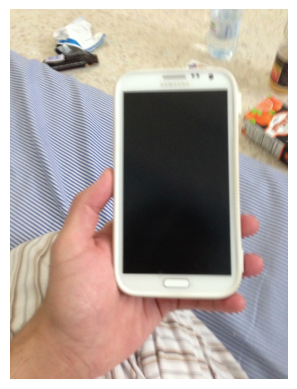

questions                                                                                                                                Is this.
answerable                                                                                                                                      1
answer_type                                                                                                                                 other
answers              [android phone, cell phone, cell phone, cellphone, samsung phone, unanswerable, phone, smart phone, white smartphone, phone]
answer_confidence                                                                      [maybe, maybe, maybe, maybe, yes, yes, yes, yes, yes, yes]
images_names                                                                                                            VizWiz_train_00000010.jpg
Name: 10, dtype: object


In [240]:
sample = data_train.iloc[10]
show_image(sample['images_names'], file_dir=IMAGES_DIR+"train/train/")
print(sample)

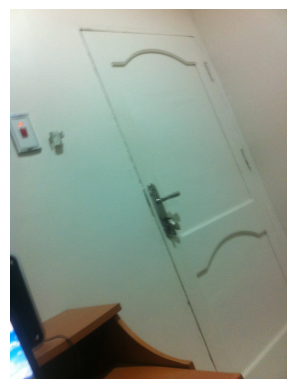

questions                                                                      Oh, what's this?
answerable                                                                                    1
answer_type                                                                               other
answers              [unanswerable, door, door, door locks, door, door, door, door, door, door]
answer_confidence                          [yes, yes, yes, yes, yes, yes, yes, yes, yes, maybe]
images_names                                                          VizWiz_train_00000190.jpg
Name: 190, dtype: object


In [241]:
sample = data_train.iloc[190]
show_image(sample['images_names'], file_dir=IMAGES_DIR+"train/train/")
print(sample)

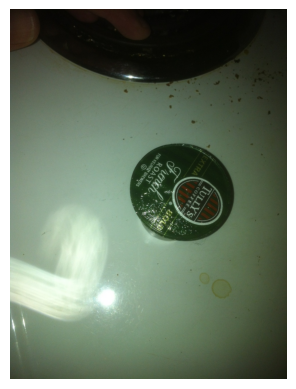

questions                                                                                                                                 What flavor and make of coffee is this, please?
answerable                                                                                                                                                                              1
answer_type                                                                                                                                                                         other
answers              [french roast tullys, tullys french roast, tullys french roast, tolls, unanswerable, unsuitable, french roast, tullys french roast, unsuitable, tullys french roast]
answer_confidence                                                                                                                   [yes, yes, yes, maybe, no, yes, maybe, yes, yes, yes]
images_names                                                          

In [242]:
sample = data_train.iloc[1500]
show_image(sample['images_names'], file_dir=IMAGES_DIR+"train/train/")
print(sample)

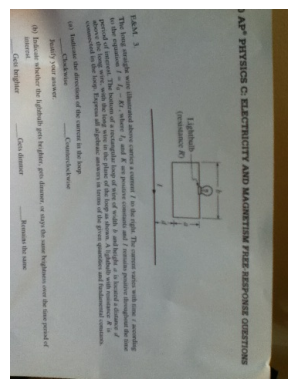

questions                                                                                                      What is the direction of the curtain loop and why?
answerable                                                                                                                                                      0
answer_type                                                                                                                                          unanswerable
answers              [unanswerable, unanswerable, unanswerable, unanswerable, unanswerable, unanswerable, unanswerable, unanswerable, unanswerable, unanswerable]
answer_confidence                                                                                                 [no, no, yes, yes, yes, yes, no, yes, yes, yes]
images_names                                                                                                                            VizWiz_train_00005000.jpg
Name: 5000, dtype: object


In [243]:
sample = data_train.iloc[5000]
show_image(sample['images_names'], file_dir=IMAGES_DIR+"train/train/")
print(sample)

In [34]:
# pick the most common answer
data_train = acc_answer(encode_confidence(data_train))
data_val = acc_answer(encode_confidence(data_val))

In [35]:
data_train

,questions,answerable,answer_type,answers,answer_confidence,images_names
0,What's the name of this product?,1,other,basil leaves,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3]",VizWiz_train_00000000.jpg
1,Can you tell me what is in this can please?,1,other,coca cola,"[3, 3, 2, 3, 3, 3, 3, 2, 2, 3]",VizWiz_train_00000001.jpg
2,Is this enchilada sauce or is this tomatoes? Thank you.,1,other,tomatoes,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3]",VizWiz_train_00000002.jpg
3,What is the captcha on this screenshot?,1,other,t36m,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 2]",VizWiz_train_00000003.jpg
4,What is this item?,1,other,solar garden light,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3]",VizWiz_train_00000004.jpg
...,...,...,...,...,...,...
20518,What's the color for this laptop?,1,other,black,"[3, 3, 3, 2, 3, 2, 3, 3, 3, 3]",VizWiz_train_00023949.jpg
20519,"(inaudible) can you see it? If so, then tell me what it is, if not tell me where to move the camera. Thank you.",1,other,unanswerable,"[2, 3, 2, 3, 2, 3, 2, 1, 2, 3]",VizWiz_train_00023950.jpg
20520,What are the three numbers I have to type?,0,unanswerable,unsuitable image,"[1, 1, 2, 3, 3, 2, 3, 2, 2, 3]",VizWiz_train_00023951.jpg
20521,Is it a box?,1,yes/no,no,"[3, 3, 2, 3, 3, 3, 2, 3, 2, 3]",VizWiz_train_00023952.jpg


In [36]:
num_classes = len(data_train["answers"].unique())
num_answers_types = len(data_train["answer_type"].unique())
(num_classes, num_answers_types)

(5247, 4)

What is this?                                                                                                                                  2721
What color is this?                                                                                                                             367
What is it?                                                                                                                                     255
What is this item?                                                                                                                              242
What does this say?                                                                                                                             199
                                                                                                                                               ... 
What color are the two colored lines on this device?  Try to be specific in terms or light or dark or grayish wh

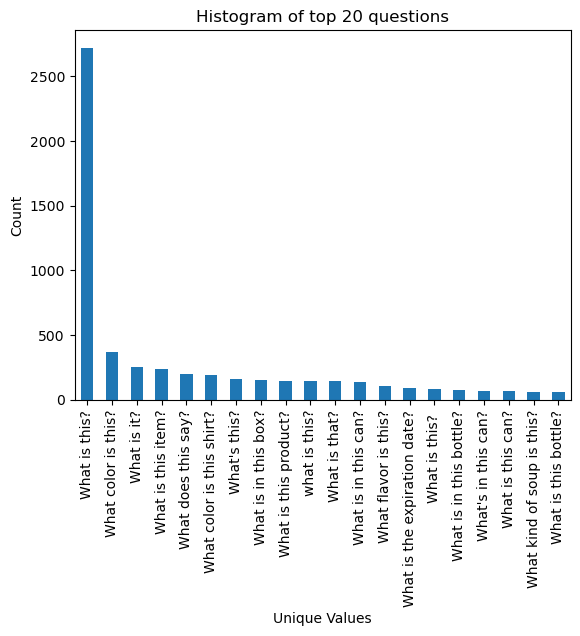

In [15]:
show_histogram_plot(data_train['questions'].value_counts(), "top 20 questions", top=20)

unanswerable                               4249
unsuitable                                 2951
no                                          575
yes                                         518
white                                       306
                                           ... 
braille                                       1
01 05 13                                      1
boxer scottie                                 1
jenny craig florentine breakfast pizzas       1
805                                           1
Name: answers, Length: 5247, dtype: int64


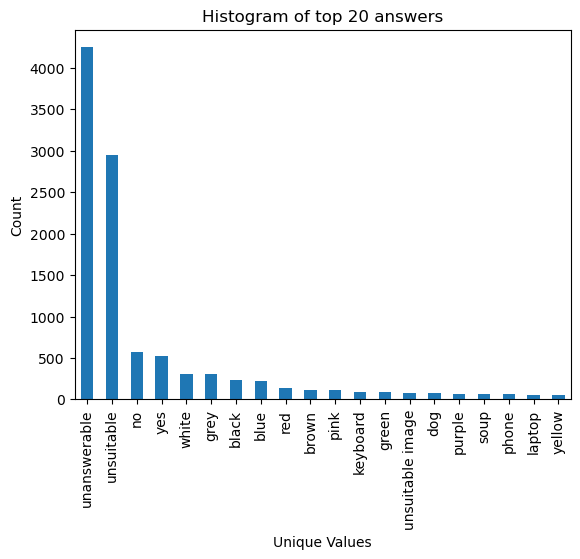

In [18]:
show_histogram_plot(data_train['answers'].value_counts(), "top 20 answers", top=20)

other           13733
unanswerable     5532
yes/no            957
number            301
Name: answer_type, dtype: int64


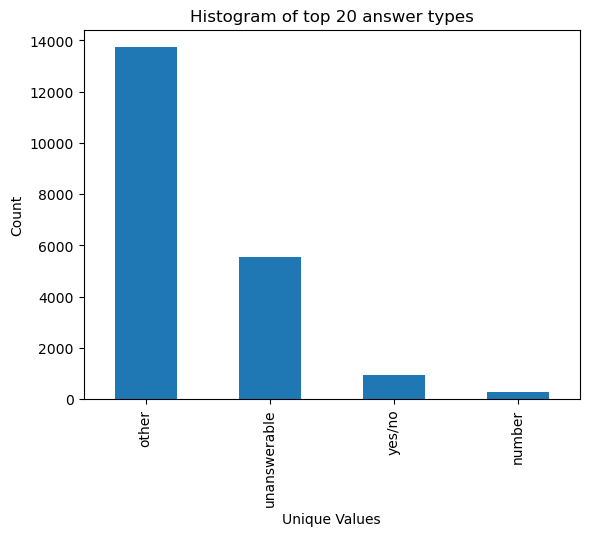

In [20]:
show_histogram_plot(data_train['answer_type'].value_counts(), "top 20 answer types", top=20)

1    14991
0     5532
Name: answerable, dtype: int64


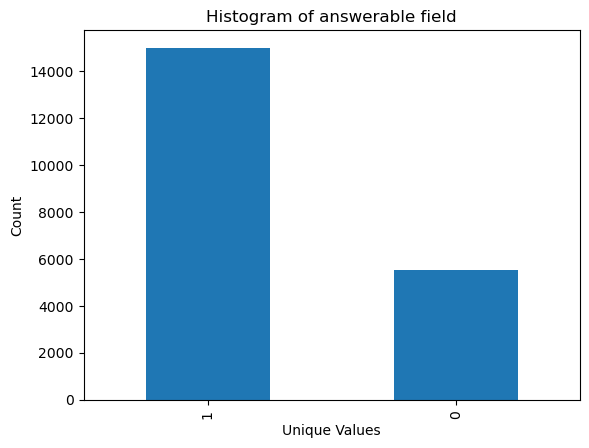

In [21]:
show_histogram_plot(data_train['answerable'].value_counts(), "answerable field")

**samples form the dataset:**

**Encoding**

In [38]:
# label encoding
answers_encoder = preprocessing.LabelEncoder()
# Encode labels in column 'answers'.
data_train["answers"]= answers_encoder.fit_transform(data_train["answers"])

answers_types_encoder = preprocessing.LabelEncoder()
# Encode labels in column 'answer_type'.
data_train["answer_type"]= answers_types_encoder.fit_transform(data_train["answer_type"])

In [39]:
# Encode labels in column 'answers'.
data_val["answers"]= answers_encoder.fit_transform(data_val["answers"])

# Encode labels in column 'answer_type'.
data_val["answer_type"]= answers_types_encoder.fit_transform(data_val["answer_type"])

## Model:

In [40]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [210]:
class EncoderDataset(Dataset):
    def __init__(self, data_df, files_dir, preprocess, tokenizer, clip_model):
        self.data = data_df
        self.preprocess = preprocess
        self.tokenizer = tokenizer
        self.clip_model = clip_model
        self.files_dir = files_dir

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # read the rows of the dataFrame
        row = self.data.iloc[idx]
        image_preprocessed = self.preprocess(Image.open(self.files_dir+row.images_names).convert('RGB').rotate(90)).unsqueeze(0).to(device)
        text_tokens = self.tokenizer(row.questions).to(device)

        
        with torch.no_grad():
            image_features = self.clip_model.encode_image(image_preprocessed)
            question_features = self.clip_model.encode_text(text_tokens)
        
        return image_features, question_features


def clip_encoder(data, files_dir):
    # Define the clip
    clip_model, preprocess = clip.load("ViT-L/14@336px", device=device)
    clip_model.to(device)

    # Define the transformations for images


    # Define the tokenizer for text
    tokenizer = clip.tokenize

    dataset = EncoderDataset(data, files_dir, preprocess, tokenizer, clip_model)
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

    encoding = []
    for image_features, question_features in dataloader:
        image_features = image_features.reshape(image_features.shape[1], image_features.shape[2]).cpu().numpy()
        question_features = question_features.reshape(question_features.shape[1], question_features.shape[2]).cpu().numpy()
        
        encoding.append(np.concatenate([image_features, question_features], axis=-1))


    data['encoding'] = encoding


In [76]:
clip_encoder(data_train, IMAGES_DIR+"train/train/")
data_train = data_train.drop(['answerable', 'answer_confidence'], axis=1)
data_train.head()

,questions,answer_type,answers,images_names,encoding
0,What's the name of this product?,1,624,VizWiz_train_00000000.jpg,"[[-0.4556, 0.8286, -0.1901, 0.1223, -0.3098, 0.1307, 0.186, -0.511, 0.2255, 0.0708, -0.03433, -0.324, -0.2527, 0.3171, -0.3271, 0.2094, 0.01826, -0.04688, -0.683, 0.5225, 0.6816, -0.3706, 0.2311, 0.374, -0.795, 0.203, -0.0863, -1.337, 0.00576, 0.255, 0.0536, 0.5527, 0.633, -0.3296, 0.281, -0.06396, -0.913, 0.10266, -0.1866, -0.3286, -0.788, 0.5435, -0.1332, -0.642, 0.785, 0.6846, 0.3555, -0.503, 0.308, 0.3062, -0.2214, -0.1342, -0.05795, 0.2021, -0.405, -0.10693, 0.5874, -0.0938, 0.9775, 0.3262, -1.025, -0.02553, -0.2688, -0.493, 0.1738, 0.4966, -0.362, -0.2262, -0.2502, -0.279, 0.3596, 0.7397, 0.9116, 0.349, -0.642, 0.04526, 0.4424, -0.2021, -0.2524, -0.246, 0.2634, 0.414, 0.623, -0.2384, 0.3445, -0.0799, 1.285, 0.547, 0.1968, 0.0158, 0.896, 0.369, -0.1927, 0.4883, -0.2249, 0.7036, 0.1134, 0.4324, -0.2375, -0.8496, ...]]"
1,Can you tell me what is in this can please?,1,1405,VizWiz_train_00000001.jpg,"[[-0.011604, 0.569, -0.10504, -0.06464, -0.605, 0.1677, 0.349, 0.1658, -0.472, -0.0939, 0.1932, -0.007153, 0.667, 0.4531, 0.0794, 0.767, -0.010056, 0.03888, 0.4097, 0.4958, -0.072, 0.2468, -0.03586, 0.758, -0.555, 0.03754, -0.5312, -0.4353, 0.11206, 0.3086, 0.421, 0.2411, -0.6885, -0.5796, -0.2668, -0.311, -0.02766, -0.02675, -0.05655, -0.1176, -0.11237, 0.4592, 0.0448, 0.1945, 0.8037, -0.0266, -0.3186, -0.1895, 0.348, -0.1294, 0.5273, 0.646, -0.275, -0.2876, 0.3962, 0.001314, 0.687, 0.3923, -0.2148, -0.0706, -0.10065, -0.5425, -0.612, -0.2361, -0.1488, 0.175, -0.1316, 0.3616, 0.4253, -0.11316, 0.263, 0.792, 0.4312, 0.306, 0.311, 0.233, -0.284, -0.1981, -0.05704, 0.527, -0.9253, 0.06082, 0.1065, -0.1383, -0.4758, -0.553, -0.2231, -0.4275, 0.093, 0.3594, 0.5713, 0.01043, -0.10535, 0.02228, -0.819, -0.0709, 0.1278, -0.4697, 0.1007, -0.3381, ...]]"
2,Is this enchilada sauce or is this tomatoes? Thank you.,1,4772,VizWiz_train_00000002.jpg,"[[0.1923, 0.06433, -0.3838, 0.095, 0.3113, -0.1885, -0.10986, -0.14, -0.1316, -0.1038, 0.03078, 0.1047, -0.4048, -0.1473, 0.006603, 0.3547, 0.12195, -0.0005627, -0.4563, -0.1373, 0.1658, -0.334, 0.4624, 0.2388, -1.013, 0.3235, -0.1987, 0.10944, 0.11804, 0.2625, 0.2583, 0.525, 0.04593, -0.7627, 0.1868, -0.4136, -0.7007, -0.02264, 0.3826, 0.321, -0.7275, 0.703, 0.6494, -0.5996, 0.8174, -0.01156, -0.3074, -0.518, 0.314, 0.618, 0.0976, 0.3735, 0.1726, 0.03186, -0.4492, 0.01602, 0.4336, 0.287, 0.7515, -0.0949, -0.429, 0.334, 0.3896, -0.509, 0.3699, 0.06964, -0.2764, 0.513, -0.3752, -0.429, -0.07477, 0.3806, 0.3823, -0.2522, 0.319, -0.06323, -0.1948, -0.509, -0.4883, -0.345, 0.4211, -0.756, 0.6, -0.552, 0.2059, -0.4548, 0.263, 0.9946, 0.3767, -0.1627, 0.1606, 0.08563, 1.039, 0.8784, 0.0747, -0.2222, -0.1831, 0.5527, 0.1567, 0.03632, ...]]"
3,What is the captcha on this screenshot?,1,4621,VizWiz_train_00000003.jpg,"[[-0.2015, 0.594, 0.1437, -0.2123, 0.569, 0.9966, -0.7666, 0.3176, -0.2595, -0.3467, -0.202, -0.2583, -0.1498, 0.1573, -0.3901, 1.079, -0.603, -0.5947, 0.2769, -0.4683, -0.3638, 0.2433, -0.06174, 0.3855, -0.4111, 0.557, 0.449, -0.3054, -0.5054, 0.03653, -0.3, -0.6045, -0.11255, -0.7603, -0.2318, -0.4368, -0.405, -0.552, -0.3987, -1.229, 0.446, 0.0783, 0.1948, 0.9624, 0.08453, 0.6875, -0.9263, -0.546, 0.1932, 0.967, -0.1696, -0.1334, 0.4988, 0.04645, -0.548, -0.0496, -0.7866, 0.11, 1.033, 0.4253, 0.305, -0.9873, 0.258, -0.388, -0.6123, 0.0498, 0.5747, 0.289, 0.3936, 0.551, 0.716, 0.1895, 0.3218, 0.665, -0.6313, -0.05103, 0.8823, -0.4395, -0.002779, -0.645, -0.493, 0.0563, 0.1371, -0.1837, 0.362, -0.4536, 0.1947, 0.468, 0.2218, 0.173, 0.738, 0.4226, -0.0882, 0.2227, 0.10205, 0.2361, -0.06805, -0.518, 0.2299, 0.3105, ...]]"
4,What is this item?,1,4358,VizWiz_train_00000004.jpg,"[[0.58, 0.815, -0.002945, 0.607, 0.1838, 0.5244, 0.577, -0.827, -0.2559, -0.2377, 0.2588, -0.5376, -0.1903, 0.5625, -0.2766, 0.4365, 0.85, -0.474, 0.586, -0.4592, 0.908, -0.5464, -0.677, -0.3438, -0.7476,

In [80]:
clip_encoder(data_val, IMAGES_DIR+"val/val/"))
data_val = data_val.drop(['answerable', 'answer_confidence'], axis=1)
data_val.head()

,questions,answer_type,answers,images_names,encoding
0,Ok. There is another picture I hope it is a better one.,2,1344,VizWiz_val_00000000.jpg,"[[-0.4443, 1.457, 0.3054, -0.283, -0.0489, -0.04443, 0.4746, 0.3486, -0.0615, 0.1274, -0.06525, -0.515, -0.0983, 0.0892, 0.487, 0.285, -0.764, 0.588, 0.1294, -0.774, -0.195, -0.05865, -0.17, -0.1233, -1.154, -0.05173, 0.3948, 0.3965, 0.2336, 0.1993, 0.3687, -0.002953, 0.4402, -0.3743, -0.387, -0.4556, -0.3362, -0.3845, -0.07355, -0.496, -0.0846, 0.7075, 0.02177, -0.2505, 0.5684, -0.5044, -0.003899, 0.1844, -0.00977, 0.006298, 0.699, -0.2388, -0.06192, -0.385, -0.2207, 0.1593, 0.709, -0.5854, -0.2084, 0.2224, 0.1537, -0.1685, -0.03802, -0.08167, 0.7217, 0.1282, 0.504, 0.585, -0.508, -0.3438, 0.3335, 0.0897, 0.08093, 0.4597, -0.2095, 0.2241, 0.1039, -0.1284, -0.585, 1.188, -0.802, -0.6514, 0.598, -0.0944, -0.863, -0.197, 0.0794, -0.2927, 0.2568, 0.2913, 0.4727, -0.6064, -0.277, 0.0394, -0.2993, 0.3547, 0.652, -0.2101, 0.785, -0.155, ...]]"
1,Can you tell me what this medicine is please?,1,924,VizWiz_val_00000001.jpg,"[[0.04767, -0.1086, -0.1183, -0.03017, 0.2168, -0.1707, 0.506, -0.543, 0.5117, 0.3232, -0.622, -0.8174, 0.2668, 0.266, -0.2798, 0.493, -1.137, 0.2993, 0.4849, -0.02715, 0.1752, 0.1742, -0.539, -0.6187, -1.26, 0.1708, 0.014305, -0.975, -0.2676, 0.505, -0.1688, -0.778, -0.9243, -0.6577, -0.322, 0.04028, -0.02837, -0.1923, -0.1628, -0.416, -0.4675, -0.1495, 0.88, -0.49, 0.4253, -0.00786, -0.02383, 0.03442, 0.5015, 0.2507, -0.1332, -0.0493, 0.0808, -0.03384, 0.09534, 0.04138, -0.4307, 1.353, 0.7705, 0.0671, 0.4016, -0.09454, 0.2725, 0.1456, -0.2554, 0.1094, -0.2295, -0.4756, 0.5527, -0.4297, -0.3535, -0.1027, 0.5645, 0.2463, -0.3352, -0.537, 0.5186, -0.1494, 0.09894, 0.4746, -0.0423, -0.4597, 0.03604, -0.2446, -0.2808, -0.6094, 0.5664, 0.6567, -0.4377, -0.08734, 0.2241, -0.434, -0.04727, 0.04758, -0.3416, -0.7417, 0.6323, 0.1853, 0.3638, -0.757, ...]]"
2,What is the title of this book?,1,502,VizWiz_val_00000002.jpg,"[[-0.4824, 0.9575, 0.2147, 0.805, -0.5557, 0.4333, 0.305, 0.1144, 0.01079, -0.41, -0.0401, -0.553, 0.2374, 1.037, 0.283, 0.2496, -0.1901, -0.2112, -0.521, -0.6787, -0.2673, -0.05646, -0.0943, -0.7773, -0.661, -0.512, 0.5654, -0.192, -0.7783, 0.3257, 0.1515, 0.721, -0.4966, -1.115, 0.529, 0.4482, 0.06052, 0.843, -0.5166, -0.9795, -0.4304, -0.4634, 0.5547, -0.0901, 0.643, -0.279, -0.3342, 0.1432, 0.11096, -1.124, 0.1866, 0.0777, 0.3093, 0.2142, 0.3245, 0.2205, -0.06134, -0.7227, -0.27, 0.5205, 0.01668, -0.3806, 0.003168, -0.3772, 0.877, 0.5415, 0.2354, -0.833, -0.2292, 0.591, -0.5493, 0.2236, 0.4507, 0.619, -0.989, 0.253, -0.746, -0.507, 0.749, -0.14, 0.05444, 0.888, 0.538, -0.1178, 0.1449, -0.59, 0.1733, 0.3708, -0.61, 0.7495, -0.3083, 0.01358, -0.455, 0.752, -0.448, 0.9375, 0.1658, -0.755, -0.0123, 0.4736, ...]]"
3,Which one is the blue one?,1,1112,VizWiz_val_00000003.jpg,"[[-0.55, 1.676, 0.344, 0.002699, 0.364, -0.1969, 0.883, 0.2644, 0.699, -0.2854, 0.318, -0.7197, -0.07166, 0.7524, 0.3708, 0.816, -0.5557, -0.768, 0.04376, -0.509, 0.1669, 0.0906, -0.914, 0.2391, -0.2874, -0.307, -0.62, -0.1874, 0.5303, 0.7246, 0.4355, -0.5547, -0.1438, -0.0644, 0.02728, 0.2, 0.01953, -0.4512, -0.2128, -0.6133, 0.3643, 0.1261, 0.244, -0.1387, 0.4158, -0.1299, 0.514, -0.3179, 0.02074, -0.592, -0.5176, -0.2197, 0.3718, 0.1302, -0.1632, 0.793, 0.882, 0.908, 0.1138, -0.1959, -0.1482, -0.05493, -0.1514, 0.6035, 0.05005, 0.2793, -0.2246, 0.3787, -0.327, 0.0066, -0.3318, 0.6025, 0.4045, -0.010475, 0.02173, 0.0931, -0.2211, -0.2212, -0.156, 0.5825, -0.3618, -0.586, 0.6655, 0.05966, -0.605, -0.1726, 0.1754, -0.0002325, 0.1401, 0.3242, 0.73, 0.1517, -0.3564, -0.3213, 0.557, -0.599, 0.5527, -0.121, 0.4004, -1.082, ...]]"
4,What does the arrow say?,2,1344,VizWiz_val_00000004.jpg,"[[-0.1179, 1.531, 0.1409, 0.11206, 1.085, 0.2286, -0.0877, 0.5215, -0.1938, 0.5273, -0.10345, 0.08624, -0.1334, -0.3623, 0.9155, 0.6167, -0.1548, 0.4548, -0.1821, -0.488, 0.515, 0.0936, 0.284, -0.2668, -1.268, 0.154, 0.

In [81]:
# Save as CSV
data_train.to_csv('data_train.csv', index=False)
data_val.to_csv('data_val.csv', index=False)

In [ ]:
# Load from CSV
data_train = pd.read_csv('data_train.csv')
data_val = pd.read_csv('data_val.csv')

In [82]:
(data_train.shape, data_val.shape)

((20523, 5), (4319, 5))

In [85]:
# data split
data_train, data_test = train_test_split(data_train, test_size=0.05, random_state=42, stratify=data_train['answer_type'])

In [86]:
(data_train.shape, data_val.shape, data_test.shape)

((19496, 5), (4319, 5), (1027, 5))

In [114]:
# Dataset class for VQA
class VQADataset(Dataset):
    def __init__(self, img_qust_encoded, answers, answers_types):
        self.endcoded_data = img_qust_encoded
        self.answers = answers
        self.answers_types = answers_types

    def __len__(self):
        return len(self.endcoded_data)

    def __getitem__(self, idx):
        encoded_data = self.endcoded_data[idx]
        answers = self.answers[idx]
        answers_types = self.answers_types[idx]

        return encoded_data, answers, answers_types

In [176]:
data_train = data_train.reset_index(drop=True)
data_test = data_test.reset_index(drop=True)
# Create the VQA dataset
train_dataset = VQADataset(data_train['encoding'], data_train['answers'], data_train['answer_type'])
test_dataset = VQADataset(data_test['encoding'], data_test['answers'], data_test['answer_type'])
val_dataset = VQADataset(data_val['encoding'], data_val['answers'], data_val['answer_type'])

In [177]:
# Create the data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [153]:
# class for VQA model
class VQAModel(nn.Module):
    def __init__(self, input_size, num_classes, num_answers_types):
        super(VQAModel, self).__init__()
        
        self.layer_norm1 = nn.LayerNorm(input_size)
        self.dropout1 = nn.Dropout(0.5)
        self.linear1 = nn.Linear(input_size, 512)
        self.layer_norm2 = nn.LayerNorm(512)
        self.dropout2 = nn.Dropout(0.5)
        # fork
        
        # answers branch
        self.linear2 = nn.Linear(512, num_classes)
        
        # answers types branch
        self.linear2_aux = nn.Linear(512, num_answers_types)

        # combined branch (output layer)
        self.linear_output = nn.Linear(num_answers_types , num_classes)
        self.sigmoid_output = nn.Sigmoid()
        


    def forward(self, combined_features):
        x = combined_features.to(self.layer_norm1.weight.dtype)
        x = self.layer_norm1(x)
        x = self.dropout1(x)
        x = self.linear1(x)
        x = self.layer_norm2(x)
        x = self.dropout2(x)
        # fork
        
        # answers branch
        ans = self.linear2(x)
        
        # answers types branch
        aux = self.linear2_aux(x)
        
        aux_ans = self.linear_output(aux)
        seg = self.sigmoid_output(aux_ans)
        # combined branch (output layer)
        out = ans * seg
        
        return out, aux

In [183]:
learning_rate = 0.001
input_size = len(data_train['encoding'].iloc[0][0])

# Instantiate the VQA model
model = VQAModel(input_size, num_classes, num_answers_types).to(device)

# utility functions
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',patience=5, factor=0.1, threshold=1e-6)

In [219]:
def model_train(data_loader, model, optimizer, loss_fn):
    total_loss = 0.0
    
    correct_predictions_ans = 0
    total_predictions_ans = 0
    
    correct_predictions_ans_type = 0
    total_predictions_ans_type = 0
    
    model.train()
    for encoded_data, answers, answers_types in data_loader:
        encoded_data = encoded_data.to(device)
        answers = answers.to(device)
        answers_types = answers_types.to(device)
        optimizer.zero_grad()
        output, aux = model(encoded_data) # model outputs 
        
        output = torch.squeeze(output, dim=1)
        aux = torch.squeeze(aux, dim=1)
        
        ans_loss = loss_fn(output, answers) # answer loss
        type_loss = loss_fn(aux, answers_types) # answer type loss
        loss = ans_loss+type_loss 
        total_loss += loss.item()
        loss.backward()
        optimizer.step()


         # Calculate accuracy (answers)
        _, predicted = torch.max(output.data, 1)
        total_predictions_ans += answers.size(0)
        correct_predictions_ans += (predicted == answers).sum().item()
        
        
        # Calculate accuracy (answers types)
        _, predicted = torch.max(aux.data, 1)
        total_predictions_ans_type += answers_types.size(0)
        correct_predictions_ans_type += (predicted == answers_types).sum().item()
       
        
    # total accuracy
    accuracy_ans = correct_predictions_ans / total_predictions_ans
    accuracy_ans_type = correct_predictions_ans_type / total_predictions_ans_type
    train_accuracy = (accuracy_ans + accuracy_ans_type) / 2
    # total loss
    train_loss = total_loss/len(data_loader)
    return train_loss, train_accuracy, accuracy_ans, accuracy_ans_type




def model_eval(data_loader, model, loss_fn):
    total_loss = 0.0
    
    correct_predictions_ans = 0
    total_predictions_ans = 0
    
    correct_predictions_ans_type = 0
    total_predictions_ans_type = 0
    
    model.eval()
    with torch.no_grad():

        for encoded_data, answers, answers_types in data_loader:
            encoded_data = encoded_data.to(device)
            answers = answers.to(device)
            answers_types = answers_types.to(device)
            output, aux = model(encoded_data) # model outputs 

            output = torch.squeeze(output, dim=1)
            aux = torch.squeeze(aux, dim=1)

            ans_loss = loss_fn(output, answers) # answer loss
            type_loss = loss_fn(aux, answers_types) # answer type loss
            loss = ans_loss+type_loss 
            total_loss += loss.item()


             # Calculate accuracy (answers)
            _, predicted = torch.max(output.data, 1)
            total_predictions_ans += answers.size(0)
            correct_predictions_ans += (predicted == answers).sum().item()
           

            # Calculate accuracy (answers types)
            _, predicted = torch.max(aux.data, 1)
            total_predictions_ans_type += answers_types.size(0)
            correct_predictions_ans_type += (predicted == answers_types).sum().item()
            
    # total accuracy
    accuracy_ans = correct_predictions_ans / total_predictions_ans
    accuracy_ans_type = correct_predictions_ans_type / total_predictions_ans_type
    eval_accuracy = (accuracy_ans + accuracy_ans_type) / 2
    # total loss
    eval_loss = total_loss/len(data_loader)
    return eval_loss, eval_accuracy, accuracy_ans, accuracy_ans_type



def predict(encoded_data, model):
    with torch.no_grad():
        output, aux = model(encoded_data) # model outputs 

        output = torch.squeeze(output, dim=1)
        aux = torch.squeeze(aux, dim=1)

        _, predicted_ans = torch.max(output.data, 1)
        _, predicted_ans_type = torch.max(aux.data, 1)
        answer = answers_encoder.inverse_transform([predicted_ans.item()])[0]
        answer_type = answers_types_encoder.inverse_transform([predicted_ans_type.item()])[0]
        
     
    return answer, answer_type

Epoch: 1/80 - Learning Rate:  0.001000
 loss:  0.9367 - accuracy:  0.8192 - val_loss:  22.4993 - val_accuracy:  0.3422
 ans_acc:  0.8005 - ans_type_acc:  0.8380 - val_ans_acc:  0.0000 - val_ans_type_acc:  0.6844
------------------------------------
Epoch: 2/80 - Learning Rate:  0.001000
 loss:  0.9212 - accuracy:  0.8232 - val_loss:  22.0382 - val_accuracy:  0.3360
 ans_acc:  0.8052 - ans_type_acc:  0.8412 - val_ans_acc:  0.0000 - val_ans_type_acc:  0.6719
------------------------------------
Epoch: 3/80 - Learning Rate:  0.001000
 loss:  0.9389 - accuracy:  0.8187 - val_loss:  22.6154 - val_accuracy:  0.3512
 ans_acc:  0.8015 - ans_type_acc:  0.8359 - val_ans_acc:  0.0000 - val_ans_type_acc:  0.7025
------------------------------------
Epoch: 4/80 - Learning Rate:  0.001000
 loss:  0.9399 - accuracy:  0.8201 - val_loss:  22.1885 - val_accuracy:  0.3479
 ans_acc:  0.8024 - ans_type_acc:  0.8378 - val_ans_acc:  0.0000 - val_ans_type_acc:  0.6958
------------------------------------
Epoc

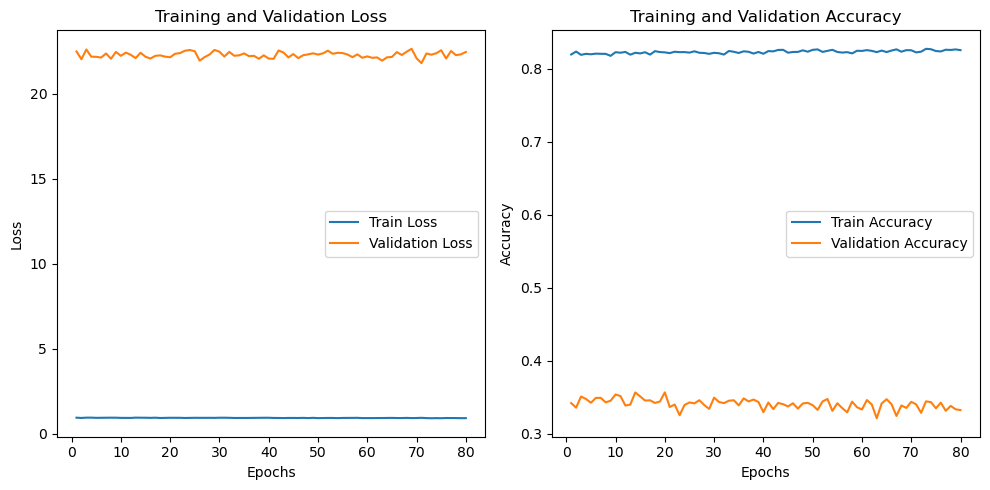

In [207]:
# Training loop
num_epochs = 80
best_loss = float('inf') # best validation loss value
early_stopping_epochs = 5 # max epochs to wait before early stopping
curr_epochs = 0 # used to count the epochs with no improvements
train_losses = []
train_accuracies = []

val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    print(f'Epoch: {epoch+1}/{num_epochs} - Learning Rate: {optimizer.param_groups[0]["lr"]: .6f}')
    
    train_loss, train_acc, train_ans_acc, train_ans_type_acc = model_train(train_loader, model, optimizer, criterion)
    val_loss, val_acc, val_ans_acc, val_ans_type_acc = model_eval(val_loader, model, criterion)

    print(f' loss: {train_loss: .4f} - accuracy: {train_acc: .4f} - val_loss: {val_loss: .4f} - val_accuracy: {val_acc: .4f}')
    print(f' ans_acc: {train_ans_acc: .4f} - ans_type_acc: {train_ans_type_acc: .4f} - val_ans_acc: {val_ans_acc: .4f} - val_ans_type_acc: {val_ans_type_acc: .4f}')
    print("------------------------------------")

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    # check for improving the learning rate
#     scheduler.step(val_loss)
    
    # check for early stop
    if val_loss >= best_loss:
        curr_epochs += 1
    else:
        curr_epochs = 0
    
    if curr_epochs >= early_stopping_epochs:
        print(f'Early stopping. No improvement for {scheduler.patience} epochs.')
        break




epochs = range(1, num_epochs + 1)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [208]:
# Testing loop

test_loss, test_acc, test_ans_acc, test_ans_type_acc = model_eval(test_loader, model, criterion)

print(f' loss: {test_loss: .4f} - accuracy: {test_acc: .4f}')
print(f' answer_accuracy: {test_ans_acc: .4f} - answer_type_accuracy: {train_ans_type_acc: .4f}')

 loss:  7.3584 - accuracy:  0.5487
 answer_accuracy:  0.4041 - answer_type_accuracy:  0.8485


In [ ]:
# evaluate the model
new_images_path = "/kaggle/input/new-images/"
new_data = pd.DataFrame({
    'images_names' : [
                    "image1.jpg",
                    "image2.png",
                    "image3.jpg",
                    "image4.jpg",
                    "image5.jpg"
                   ]
    ,'questions'  : [
                   "what is this?",
                   "what is the type of this vehicle?",
                   "what is this?",
                   "what is this?",
                   "what is the color?"]
    })
# encoding
clip_encoder(new_data, new_images_path)
new_data.head()


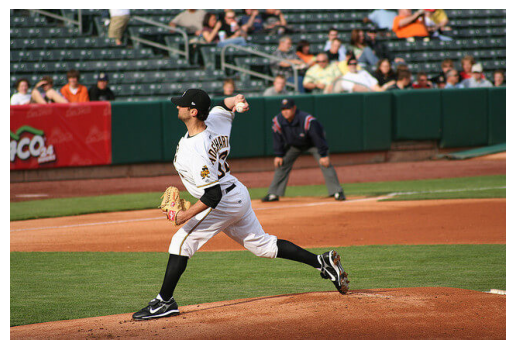

what is this?
predicted answer:unanswerable, and the type: other


In [232]:
sample = new_data.iloc[0]
show_image(sample['images_names'],file_dir=new_images_path)
print(sample['questions'])
answer, answer_type = predict(torch.tensor(sample['encoding']).to(device), model)
print(f"predicted answer:{answer}, and the type: {answer_type}")

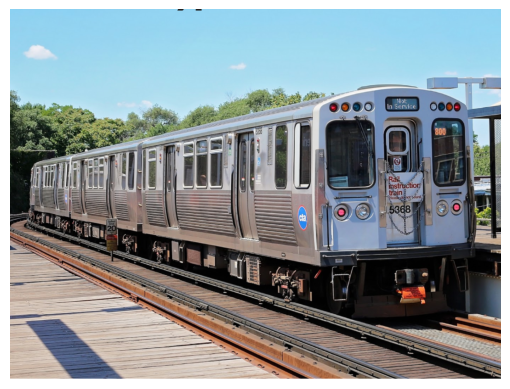

what is the type of this vehicle?
predicted answer:unanswerable, and the type: unanswerable


In [233]:
sample = new_data.iloc[1]
show_image(sample['images_names'],file_dir=new_images_path)
print(sample['questions'])
answer, answer_type = predict(torch.tensor(sample['encoding']).to(device), model)
print(f"predicted answer:{answer}, and the type: {answer_type}")

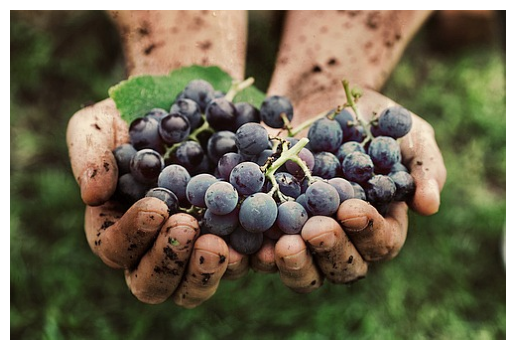

what is this?
predicted answer:unanswerable, and the type: other


In [234]:
sample = new_data.iloc[2]
show_image(sample['images_names'],file_dir=new_images_path)
print(sample['questions'])
answer, answer_type = predict(torch.tensor(sample['encoding']).to(device), model)
print(f"predicted answer:{answer}, and the type: {answer_type}")

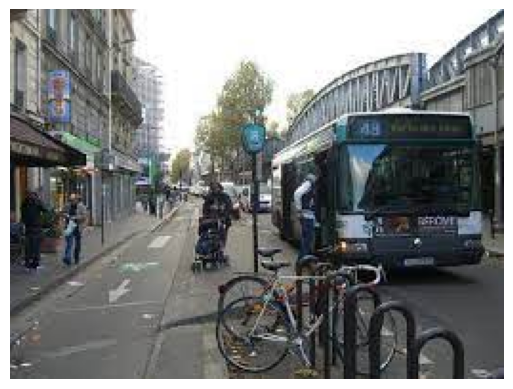

what is this?
predicted answer:unanswerable, and the type: unanswerable


In [236]:
sample = new_data.iloc[3]
show_image(sample['images_names'],file_dir=new_images_path)
print(sample['questions'])
answer, answer_type = predict(torch.tensor(sample['encoding']).to(device), model)
print(f"predicted answer:{answer}, and the type: {answer_type}")

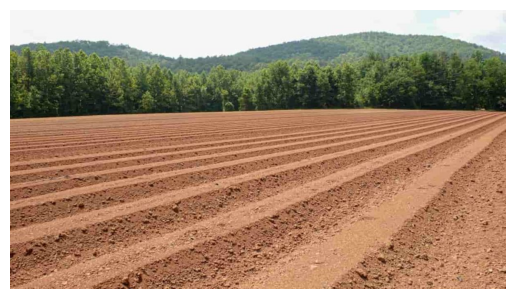

what is the color?
predicted answer:black, and the type: other


In [238]:
sample = new_data.iloc[4]
show_image(sample['images_names'],file_dir=new_images_path)
print(sample['questions'])
answer, answer_type = predict(torch.tensor(sample['encoding']).to(device), model)
print(f"predicted answer:{answer}, and the type: {answer_type}")